# Feature Selection
Feature Selection is one of the core concepts in machine learning which hugely impacts the performance of your model. The data features that you use to train your machine learning models have a huge influence on the performance you can achieve.

Irrelevant or partially relevant features can negatively impact model performance.

## Benefits of performing feature selection:

- **Reduces Overfitting:** Less redundant data means less 
opportunity to make decisions based on noise(irrelevant data).
- **Improves Accuracy:** Less misleading data means model's accuracy improves.
- **Reduces Training Time:** Less data means that algorithms train faster.

Out of the numerous feature selection techniques, we'll be discussing 4 here.

1. Recursive Feature Elimination (RFE)
2. Feature Importance using Random Forest Classifier
3. Boruta
4. XGBoost

**All the techniques will be implemented independent of each other and not in succession.**


## About Dataset
**Context** 

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Content**

The datasets consists of several medical predictor variables and one target variable, class (whether patient have diabetes or not). Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

**Data Description**

*  **preg:** Number of times the patient had been pregnant
*  **glucose:** Plasma glucose concentration a 2 hours in an oral glucose tolerance test
*  **bp:** Diastolic blood pressure (mm Hg)
*  **skin:** Triceps skin fold thickness (mm)
*  **insulin:** 2-Hour serum insulin (mu U/ml)
*  **bmi:** Body mass index (weight in kg/(height in m)^2)
*  **pedi:** Diabetes pedigree function
*  **age:** Age of the patient in years
*  **class:** Have diabetes or not (0 means have no diabetes; 1 means have diabetes);  268 of 768 are 1, the others are 0

You can take the help of google to know more about some of the medical terms used here.

In [ ]:
# Importing packages
import numpy as np # for array related operations
import pandas as pd # to read csv
import matplotlib.pyplot as plt # for visualisation
import seaborn as sns # for visualisation

# ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# load data

col_names = ['preg', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedi', 'age', 'class']
data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/pima-indians-diabetes.csv", names=col_names)
# names=col_names assigns the given names to the DataFrame columns (just to make the names shorter)

data.head()

,preg,glucose,bp,skin,insulin,bmi,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   preg     768 non-null    int64  
 1   glucose  768 non-null    int64  
 2   bp       768 non-null    int64  
 3   skin     768 non-null    int64  
 4   insulin  768 non-null    int64  
 5   bmi      768 non-null    float64
 6   pedi     768 non-null    float64
 7   age      768 non-null    int64  
 8   class    768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
data['class'].value_counts()

0    500
1    268
Name: class, dtype: int64

## Correlation Matrix with Heatmap
Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

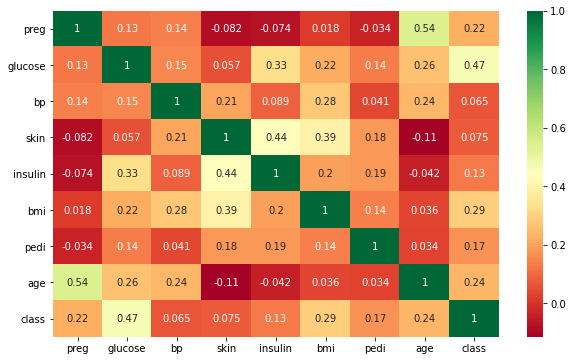

In [ ]:
#get correlations of each features in dataset
corrmat = data.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corrmat, annot=True, cmap="RdYlGn")

We can see from an initial analysis of the heatmap that glucose, bmi, age, preg, pedi and insulin are the top 6 features that have relatively high correlation(positive) with class(our target variable). It means that as they increase, diabetes of the patient also increases.

Also, age and preg are highly correlated with each other.

Now, you might say why not remove irrelevant features by intuition or just looking at the heatmap?

In general **it’s advisable not to be influenced by one’s bias or intuition**.

In a real-life situation, we would have to deal with more than 3 features (from some hundreds to many thousands, typically). Thus, it would be unfeasible to go through each of them and decide whether to keep it or not. Moreover, there might be relationships among variables that are not easily spotted by a human eye, not even with accurate analysis.

Ideally, we would like to find an algorithm that is able to autonomously decide whether any given feature of X bears some predictive value about y.

In [ ]:
# Splitting data into Input and Target Variable

y = data['class']  # target variable i.e diabetic or not
X = data.drop(['class'], axis=1)  # input variables

In [ ]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=8)

## Basic Steps
The steps that we'll follow will look like:
- Train a baseline classifier ( any classifier like logistic regression or random forest trained with all the features in dataset)
- Identify the most important features using a feature selection technique
- Create a new ‘limited features’ dataset containing only those features
-  Train a second classifier on this new dataset
- Compare the accuracy of the ‘full featured’(baseline) classifier to the accuracy of the ‘limited featured’(new) classifier

## Baseline Model

This is the basic Logistic Regression model we'll use to check if the first feature selection technique makes any improvements.

In [ ]:
# Building the Logistic Regression model
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()      
lr_baseline_model = clf_lr.fit(X_train,y_train)

In [ ]:
# Noting down accuracy of the baseline model
from sklearn.metrics import accuracy_score, f1_score

# finding our predicted values
y_pred = lr_baseline_model.predict(X_test)

# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test ,y_pred)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score:", f_score)

Baseline Model Accuracy: 0.7677165354330708
Baseline Model F1 Score: 0.6143790849673203


# Now let's start implementing feature selection and see if it makes any difference!

## 1. Recursive Feature Elimination (RFE)

Recursive = Something that happens repeatedly

As the name suggests, Recursive Feature Elimination works by recursively(repeatedly) removing features and building a model on the features that remain.

It uses model accuracy to identify which features (and combinations of attributes) contribute the most to predicting the target variable.

The example below uses RFE with the logistic regression algorithm to select the top 3 features. The choice of algorithm does not matter, instead of logistic we can use any other algorithm that is skillful and consistent.

In [ ]:
from sklearn.feature_selection import RFE

# feature extraction
rfe = RFE(estimator= clf_lr , step = 1) 
# estimator is the model we're taking as the baseline model (basic model)
# step = 1: removes one feature at a time and then builds a model on the remaining features
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.
# we can even provide no. of features as an argument 

In [ ]:
# Fit the function for ranking the features
fit = rfe.fit(X_train, y_train)

In [ ]:
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 4
Selected Features: [ True  True False False False  True  True False]
Feature Ranking: [1 1 2 4 5 1 1 3]


Through the output mentioned above we can't understand which feature has a better rank unless we see the index of each. In order to better visualise, we can put it in the form of a table with ranking as mentioned below.

In [ ]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
0,preg,1
1,glucose,1
5,bmi,1
6,pedi,1
2,bp,2
7,age,3
3,skin,4
4,insulin,5


You can see that RFE gives preg, glucose, bmi and pedi the first rank. 

### Apply the transformation on to dataset

Now that we have obtained which features have the best score, we'll use only those features to fit the model. 

.transform() reduces our data to the selected features. Always remember that train and test data is transformed separately.

In [ ]:
# Transforming the data
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [ ]:
# Fitting our baseline model with the transformed data
lr_rfe_model = clf_lr.fit(X_train_rfe, y_train)

In [ ]:
# making predictions
y_pred = lr_rfe_model.predict(X_test_rfe)

In [ ]:
# evaluating the model
rfe_ac = accuracy_score(y_test, y_pred)
rfe_fscore = f1_score(y_test ,y_pred)

print("RFE Model Accuracy:", rfe_ac)
print("RFE Model F1 Score:", rfe_fscore)

RFE Model Accuracy: 0.7716535433070866
RFE Model F1 Score: 0.6375


We can see an improvement in both accuracy and F1 score. 

Accuracy:  0.7677165354330708  ---> 0.7716535433070866

F1 Score: 0.6143790849673203 ---> 0.6375


## 2. Feature Importance using Random Forest

Feature importance is the technique used to select features using a trained supervised classifier. It gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Bagged decision trees models like Random Forest can be used to estimate the importance of features.



### Train A Random Forest Classifier (Baseline Model)

In [ ]:
# import random forest classifier from sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Create a random forest classifier
rf_clf = RandomForestClassifier(n_estimators=10000, random_state=1, n_jobs=-1)

# n_estimators = The number of trees in the forest.
# njobs: The number of jobs to run in parallel. -1 means using all processors.
# Further information about parameters of random forest classifier: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# Train the classifier
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

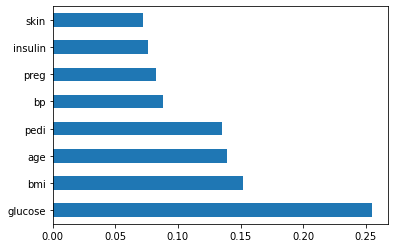

In [ ]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)     # Creating series of feature importances with column names as indexes
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The scores above are the importance scores for each variable. There are two things to note. First, all the importance scores add up to 100%. 

Second, glucose, bmi, age, pedi are the top 4 features. The individual score of each is above 0.13. When combined, these 4 features have an importance of around 67.8%. 


### Identify And Select Most Important Features

In [ ]:
from sklearn.feature_selection import SelectFromModel
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.13 ( all top 4 features lie above this)

# rf_sfm = SelectFromModel(rf_clf, threshold=0.13)
# It will select the same 4 features even without specifying the threshold:
rf_sfm = SelectFromModel(rf_clf)

In [ ]:
# Train the selector
rf_sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=10000, n_jobs=-1,
                                                 oob_score=False,

### Create A Data Subset With Only The Most Important Features

In [ ]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = rf_sfm.transform(X_train)
X_important_test = rf_sfm.transform(X_test)

### Train A New Random Forest Classifier Using Only Most Important Features

In [ ]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [ ]:
# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Compare The Accuracy Of Our Full Feature Classifier To Our Limited Feature Classifier

In [ ]:
# predict for X_test
y_pred = rf_clf.predict(X_test)

In [ ]:
# Calculating accuracy score and f1 score for our baseline model i.e. model with 8 features
rf_ac = accuracy_score(y_test, y_pred)
rf_fscore = f1_score(y_test ,y_pred)

# View The Accuracy Of Our Full Feature (8 Features) Model
print("Baseline Model Accuracy:", rf_ac)
print("Baseline Model F1 Score:", rf_fscore)

Baseline Model Accuracy: 0.7637795275590551
Baseline Model F1 Score: 0.620253164556962


In [ ]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

In [ ]:
# Calculating accuracy score and f1 score for our limited feature (4 features) model
rf_imp_ac = accuracy_score(y_test, y_important_pred)
rf_imp_fscore = f1_score(y_test, y_important_pred)

# View The Accuracy Of Our Limited Feature (4 Features) Model
print("Limited Features Model Accuracy:", rf_ac)
print("Limited Features Model F1 Score:", rf_fscore)

Limited Features Model Accuracy: 0.7637795275590551
Limited Features Model F1 Score: 0.620253164556962


As can be seen by the above metrics, the accuracy and F1 Score of our original model which contained all eight features and ‘limited’ model which contained only two features is the same. 
We have halved the number of features in the model without changing the accuracy which is great!

## 3. Boruta
 Boruta is an **all-relevant feature selection method**. Unlike other techniques that select small set of features that minimize the error, Boruta tries to capture all the important and interesting features you might have in your dataset with respect to the target variable.

Boruta by default uses random forest although it works with other algorithms like LightGBM, XGBoost etc.

NOTE:  BorutaPy accepts numpy arrays only.

You can install Boruta with the command
```
pip install Boruta
```



In [ ]:
!pip install Boruta

     |████████████████████████████████| 61kB 1.9MB/s 


In [ ]:
# import BorutaPy class from boruta library
from boruta import BorutaPy

In [ ]:
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=0)

In [ ]:
# build the random forest model
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# predicting for X_test
y_pred = forest.predict(X_test)

In [ ]:
# Calculating accuracy score and f1 score for model with full features
ac = accuracy_score(y_test, y_pred)
fscore = f1_score(y_test ,y_pred)

# View The Accuracy Of Our Full Feature (8 Features) Model
print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score:", fscore)

Baseline Model Accuracy: 0.7874015748031497
Baseline Model F1 Score: 0.7244897959183672


#### Boruta Feature Selection

In [ ]:
# define Boruta feature selection method
# boruta_selector = BorutaPy(forest, n_estimators='auto', verbose=2)
boruta_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

In [ ]:
# find all relevant features
boruta_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	17 / 

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=5,
                                          max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=69, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F01F4CFB990,
                                          verbose=0, warm_start=F

As you saw above, Boruta categorises features into 3 categories - Confirmed, Tentative and Rejected. 

The features in the Tentative category are worked upon and put into one of Confirmed or Rejected. The Confirmed category features are said to be the significant/important features. 

In [ ]:
# check selected features
print("Selected Features: ", boruta_selector.support_)
 
# check ranking of features
print("Ranking: ",boruta_selector.ranking_)

print("No. of significant features: ", boruta_selector.n_features_)

Selected Features:  [False  True False False  True  True  True  True]
Ranking:  [2 1 4 3 1 1 1 1]
No. of significant features:  5


In [ ]:
# Let's visualise it better in the form of a table
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':boruta_selector.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
1,glucose,1
4,insulin,1
5,bmi,1
6,pedi,1
7,age,1
0,preg,2
3,skin,3
2,bp,4


Our model gave glucose, insulin, bmi, pedi and age the first rank.

### Transformation using selected features
Let's create a dataset with only these 5 features now.

In [ ]:
X_important_train = boruta_selector.transform(np.array(X_train))
X_important_test = boruta_selector.transform(np.array(X_test))

In [ ]:
# Create a new random forest classifier for the most important features
rf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [ ]:
# Train the new classifier on the new dataset containing the most important features
rf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = rf_important.predict(X_important_test)

In [ ]:
# Calculate accuracy score and f1 score for limited feature model
rf_imp_ac = accuracy_score(y_test, y_important_pred)
rf_imp_fscore = f1_score(y_test, y_important_pred)

# View The Accuracy Of Our Limited Feature (4 Features) Model
print("Limited Features Boruta Model Accuracy:", rf_imp_ac)
print("Limited Features Boruta Model F1 Score:", rf_imp_fscore)

Limited Features Boruta Model Accuracy: 0.7755905511811023
Limited Features Boruta Model F1 Score: 0.6459627329192545


Accuracy: 0.7874015748031497 -----> 0.7755905511811023

F1 Score: 0.7244897959183672 -----> 0.6459627329192545

The Accuracy and F1 Score dropped a bit on using Boruta. The no. of features have dropped from 8 to 5 however. This might be useful in cases where we want to reduce dimensionality even with some reduction in accuracy metrics.

## 4. XGBoost
**Xgboost** is short for e**X**treme **G**radient **Boost**ing package.

XGBoost model has the best combination of prediction performance and processing time compared to other algorithms. No wonder it is widely used in recent Data Science competitions.




MUST READ: Learn about XGBoost here:
https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

In [ ]:
# Importing libraries
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
# fit model to training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Feature Importances :  [0.0746821  0.32840726 0.07829193 0.07849974 0.07324519 0.12814122
 0.09585145 0.14288114]


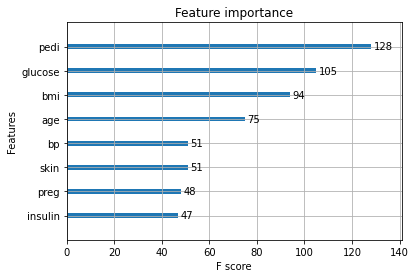

In [ ]:
print("Feature Importances : ", xgb_model.feature_importances_)

# plot feature importance
plot_importance(xgb_model)
plt.show()

XGBoost tells us that pedi, glucose, bmi and age are the top 4 features.


In [ ]:
# Getting feature importance coefficients
xgb_model.feature_importances_

array([0.0746821 , 0.32840726, 0.07829193, 0.07849974, 0.07324519,
       0.12814122, 0.09585145, 0.14288114], dtype=float32)

In [ ]:
# predict for X_test
y_pred = xgb_model.predict(X_test)

In [ ]:
# Calculate accuracy and and f1 score
xgb_ac = accuracy_score(y_test, y_pred)
xgb_fscore = f1_score(y_test ,y_pred)

print("XGB Baseline Model Accuracy:", xgb_ac)
print("XGB Baseline Model F1 Score:", xgb_fscore)

XGB Baseline Model Accuracy: 0.7598425196850394
XGB Baseline Model F1 Score: 0.6432748538011697


In [ ]:
selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)

# Transform the train and test features
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test) 

# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)

# Evaluating the model
predictions = selection_model.predict(select_X_test)      # predict for selected features of X_test
xgb_accuracy = accuracy_score(y_test, predictions)        # Calculating accuracy score on test data
xgb_fscore = f1_score(y_test , predictions) 


# View The Accuracy Of Our Limited Feature (4 Features) Model
print("Limited Features Boruta Model Accuracy:", rf_imp_ac)
print("Limited Features Boruta Model F1 Score:", rf_imp_fscore)

Limited Features Boruta Model Accuracy: 0.7755905511811023
Limited Features Boruta Model F1 Score: 0.6459627329192545


In [ ]:
from numpy import sort

# sort the thresholds (i.e. feature importances)
thresholds = sort(xgb_model.feature_importances_)

In [ ]:
# Fit model using each importance as a threshold

for thresh in thresholds:

  # select features using threshold
  selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)

  # Transform the train features
  select_X_train = selection.transform(X_train)

  # train model
  selection_model = XGBClassifier()
  selection_model.fit(select_X_train, y_train)
  
  # Evaluating the model
  select_X_test = selection.transform(X_test)               # Transform the test features
  predictions = selection_model.predict(select_X_test)      # predict for selected features of X_test
  xgb_accuracy = accuracy_score(y_test, predictions)        # Calculating accuracy score on test data
  xgb_fscore = f1_score(y_test , predictions)               # Calculating f1 score on test data

  # print the threshold value, number of features, accuracy, f1 score
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, F1 Score:%.3f " % (thresh, select_X_train.shape[1], xgb_accuracy*100.0, xgb_fscore))

Thresh=0.073, n=8, Accuracy: 75.98%, F1 Score:0.643 
Thresh=0.075, n=7, Accuracy: 76.77%, F1 Score:0.659 
Thresh=0.078, n=6, Accuracy: 77.56%, F1 Score:0.663 
Thresh=0.078, n=5, Accuracy: 76.77%, F1 Score:0.647 
Thresh=0.096, n=4, Accuracy: 75.98%, F1 Score:0.639 
Thresh=0.128, n=3, Accuracy: 77.95%, F1 Score:0.678 
Thresh=0.143, n=2, Accuracy: 74.41%, F1 Score:0.606 
Thresh=0.328, n=1, Accuracy: 72.83%, F1 Score:0.561 


XGBoost was able to achieve a pretty good accuracy and F1 Score keeping threshold as 0.128( selects only 3 features- pedi, glucose and bmi). 

Accuracy: 0.7598425196850394 ---> 0.7795

F1 Score: 0.6432748538011697 ---> 0.678



## Conclusion

- We started with observing the heatmap of our data and derived glucose, bmi, age, preg, pedi and insulin to be the top 6 positively correlated features.
- Our baseline Logistic Regression model using all the features gave an accuracy of 0.767 and F1 Score of 0.614.
- On implementing the Recursive Feature Elimination technique(claimed preg, glucose, bmi, pedi as top 4 features) on Logistic Regression model, we observed significant change in both the metrics. The accuracy improved to 0.771 and F1 Score to 0.637.
- Feature Importance technique using RandomForestClassifier stated that glucose, age, bmi, pedi and preg are the most important features of our dataset. Using this, we were able to half the number of features in the model without changing the accuracy.
- Boruta didn't improve the accuracy but was able to reduce the number of features to 5.
- XGBoost gave the best results by giving an accuracy of 0.7795 and F1 Score of 0.678.
- After implementing the 4 techniques, we can see that all of them gave us similar set of important features. 



## General Advice
- Start with simple techniques.
- Always check if what you're doing is helping(increasing your model's accuracy) or hurting. 
- Don't assume that any given technique is useful.
- Not all the feature selection techniques are available in Sklearn. When you're coding a technique on your own, it's easier to make mistakes and that's a lot of work. Therefore, it's better to first focus on the techniques built in Sklearn itself. 
- Feature selection is a decisive part of a machine learning pipeline: being too conservative means introducing unnecessary noise, while being too aggressive means throwing away useful information.


Watch this video you want to learn more about other feature selection techniques: https://www.youtube.com/watch?v=YaKMeAlHgqQ